In [1]:
import pandas as pd

In [2]:
result_names = ["full", "eugene"]

In [11]:
import os
import torch
import numpy as np
from pathlib import Path

# bpnet-lite

In [2]:
from bpnetlite.io import extract_loci
from bpnetlite.io import PeakGenerator

In [5]:
# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
reference_dir = "/cellar/users/aklie/data/eugene/avsec21/reference"
peaks = os.path.join(data_dir, "peaks.bed")
seqs = "/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa"
signals = [os.path.join(data_dir, "plus.bw"), os.path.join(data_dir, "minus.bw")]
controls = [os.path.join(data_dir, "control_plus.bw"), os.path.join(data_dir, "control_minus.bw")]

In [ ]:
# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Create a dataloader for the training peaks, this takes about just under 4 minutes to complete
training_data = PeakGenerator(peaks, seqs, signals, controls, chroms=training_chroms)

In [6]:
len(training_data)

1432

In [7]:
training_data.batch_size

32

In [4]:
# Grab the validation data, no jittering, augmenting, or shuffling, takes about 30 seconds
X_valid, y_valid, X_ctl_valid = extract_loci(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)

# SeqData

In [12]:
import xarray as xr
import seqdata as sd
import seqpro as sp
from eugene import preprocess as pp

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
fasta = Path("/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa")
peaks = data_dir / "peaks.bed"
signals = [data_dir / "plus.bw", data_dir / "minus.bw"]
controls = [data_dir / "control_plus.bw", data_dir / "control_minus.bw"]
control_samples = ['plus', 'minus']
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/dlaub/projects/ML4GLand/use_cases/avsec21/avsec21.zarr'

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

In [13]:
# Load in the SeqData
sdata = sd.open_zarr(out)

# Split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])

# Need to upper case the seqs for ohe
sdata["cleaned_seq"] = xr.DataArray(np.char.upper(sdata["seq"]), dims=["_sequence", "_length"])

# Load the training data into memory for faster training
sdata[['cleaned_seq', 'control', 'signal']].load()

# Keep only training and validation chromosomes
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms)) | (sdata["chrom"].isin(valid_chroms))).compute())

# Train-test split based on chromosomes
pp.train_test_chrom_split(sdata, test_chroms=valid_chroms)
sdata_train = sdata.sel(_sequence=(sdata["train_val"]==True).compute())
sdata_valid = sdata.sel(_sequence=(sdata["train_val"]==False).compute())

In [1]:
# Define training transformations
from eugene.dataload._augment import RandomRC

def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=128, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    return RandomRC()(*x)

# Get the train dataloader
dl = sd.get_torch_dataloader(
    sdata_train,
    sample_dims=['_sequence'],
    variables=['cleaned_seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('cleaned_seq', 'control', 'signal'): jitter,
        'cleaned_seq': seq_trans,
        'signal': lambda x: x[..., 557:-557],
        ('control', 'signal'): cov_dtype,
        ('control', 'cleaned_seq', 'signal'): to_tensor,
        ('signal', 'control', 'cleaned_seq'): random_rc
    },
    shuffle=True,
    return_tuples=True
)

KeyboardInterrupt: 

In [17]:
len(dl)

1432

In [1]:
from eugene import plot as pl

In [7]:
%matplotlib inline

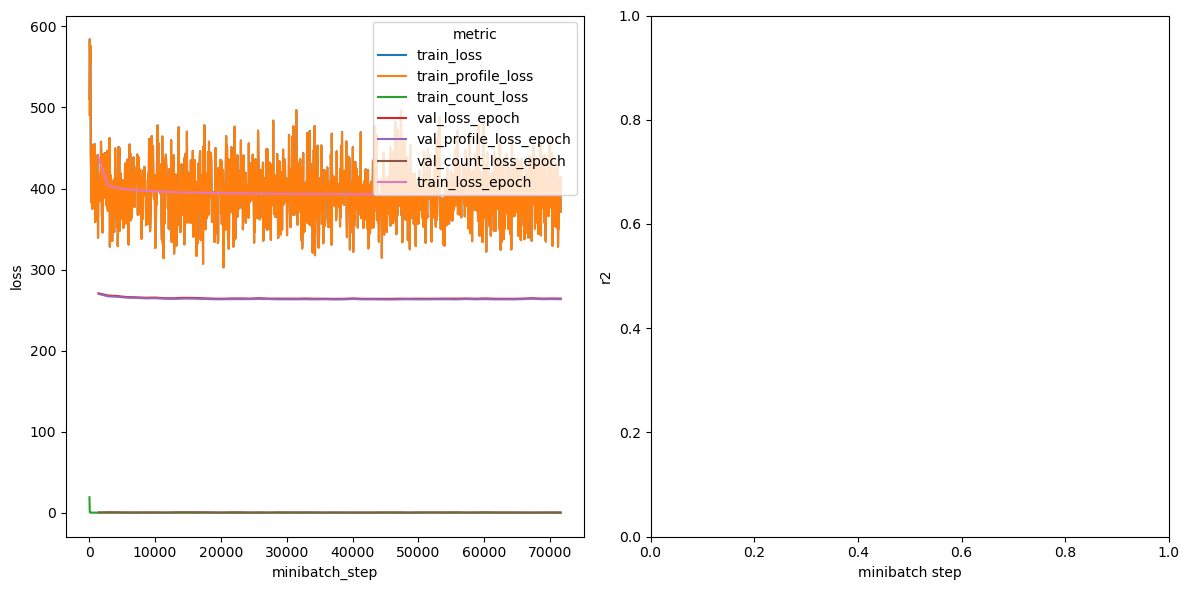

In [2]:
pl.training_summary("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/BPNet/v4")

In [4]:
import pandas as pd

In [8]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import traceback
def tflog2pandas(path: str) -> pd.DataFrame:
    """
    Convert single tensorflow log file to pandas DataFrame

    Takes in the filepath to a tensorflow log file and converts it to a pandas
    DataFrame. The index of the DataFrame is the step number.

    Parameters
    ----------
    path : str
        path to tensorflow log file

    Returns
    -------
    pd.DataFrame
        converted dataframe

    Note
    ----
    Extraction function modified from
    https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data.reset_index(drop=True)

In [10]:
df = tflog2pandas("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/BPNet/v4/events.out.tfevents.1687398202.carter-gpu-01.1151710.4")

In [20]:
# Keep only the columns with epoch in the name and drop the exact "epoch" value
df = df[df['metric'].str.contains('epoch')]
df = df[df['metric'] != 'epoch']

In [21]:
df["step"]

,metric,value,step
5829,val_loss_epoch,270.847412,1431.0
5830,val_loss_epoch,268.144775,2863.0
5831,val_loss_epoch,267.465454,4295.0
5832,val_loss_epoch,266.231659,5727.0
5833,val_loss_epoch,265.921204,7159.0
...,...,...,...
6124,train_loss_epoch,392.242615,65871.0
6125,train_loss_epoch,392.340515,67303.0
6126,train_loss_epoch,392.268158,68735.0
6127,train_loss_epoch,392.207977,70167.0


In [23]:
df["step"].value_counts()

1431.0     6
54415.0    6
40095.0    6
41527.0    6
42959.0    6
44391.0    6
45823.0    6
47255.0    6
48687.0    6
50119.0    6
51551.0    6
52983.0    6
55847.0    6
2863.0     6
57279.0    6
58711.0    6
60143.0    6
61575.0    6
63007.0    6
64439.0    6
65871.0    6
67303.0    6
68735.0    6
70167.0    6
38663.0    6
37231.0    6
35799.0    6
34367.0    6
4295.0     6
5727.0     6
7159.0     6
8591.0     6
10023.0    6
11455.0    6
12887.0    6
14319.0    6
15751.0    6
17183.0    6
18615.0    6
20047.0    6
21479.0    6
22911.0    6
24343.0    6
25775.0    6
27207.0    6
28639.0    6
30071.0    6
31503.0    6
32935.0    6
71599.0    6
Name: step, dtype: int64

In [24]:
# Flatten the df to make the step the index
flattened_df = df.pivot(index='step', columns='metric', values='value')

metric,train_loss_epoch,val_count_corr_epoch,val_count_loss_epoch,val_loss_epoch,val_profile_corr_epoch,val_profile_loss_epoch
step,,,,,,
1431.0,437.723328,0.292861,0.725085,270.847412,0.407059,270.122314
2863.0,403.583923,0.363934,0.977615,268.144775,0.415302,267.167206
4295.0,400.748596,0.356503,0.946092,267.465454,0.418510,266.519409
5727.0,399.091553,0.328651,0.712521,266.231659,0.420751,265.519196
7159.0,397.945557,0.360552,0.742331,265.921204,0.421732,265.178864
8591.0,397.178925,0.334724,0.764620,265.392212,0.423546,264.627594
10023.0,396.648895,0.339879,0.818781,265.605530,0.424625,264.786682
11455.0,396.090637,0.364121,0.644611,264.847260,0.425035,264.202637
12887.0,395.642609,0.356877,0.831589,264.742859,0.426551,263.911346


In [12]:
df["metric"].unique()

array(['hp_metric', 'train_loss', 'train_profile_loss',
       'train_count_loss', 'epoch', 'val_loss_epoch',
       'val_profile_loss_epoch', 'val_count_loss_epoch',
       'val_profile_corr_epoch', 'val_count_corr_epoch',
       'train_loss_epoch'], dtype=object)

In [ ]:
df["metric"].unique()

In [ ]:
df["met"]

In [ ]:
# Check how many b'N' characters exist in "cleaned_seq"
(sdata["cleaned_seq"] == b"N").sum().values

# Figs

In [3]:
import pandas as pd

In [4]:
bpnetlite = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/full/bpnet.full.log", sep="\t")
seqdata_bpnetlite = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/seqdata/bpnet.seqdata.log", sep="\t")

In [5]:
import matplotlib.pyplot as plt

In [6]:
bpnetlite

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?
0,0,0,32.477757,2.069815,665.659058,23.724564,804.949524,-0.000055,-0.342656,11.642741,True
1,0,100,4.041414,1.255255,500.297943,2.162027,339.983765,0.094198,-0.121059,1.724210,True
2,0,200,3.211013,1.257862,484.207886,0.849016,317.341064,0.217905,-0.105027,0.745708,True
3,0,300,3.221344,1.257865,409.543945,0.763297,294.171143,0.314060,-0.135239,0.710423,True
4,0,400,3.221671,1.258229,472.894592,0.581206,283.408905,0.355451,-0.113448,0.927415,True
...,...,...,...,...,...,...,...,...,...,...,...
711,49,71100,3.251304,1.266637,388.442383,0.242734,263.589264,0.427326,0.740808,0.765566,False
712,49,71200,3.248209,1.266646,431.840790,0.271780,263.266907,0.427454,0.740565,0.810823,False
713,49,71300,3.249945,1.266716,396.557434,0.321139,263.755249,0.426996,0.736262,0.716457,False
714,49,71400,3.241341,1.266684,399.839355,0.305385,263.531158,0.426921,0.741811,0.743607,False


In [15]:
bpnetlite.columns

Index(['Epoch', 'Iteration', 'Training Time', 'Validation Time',
       'Training MNLL', 'Training Count MSE', 'Validation MNLL',
       'Validation Profile Pearson', 'Validation Count Pearson',
       'Validation Count MSE', 'Saved?'],
      dtype='object')

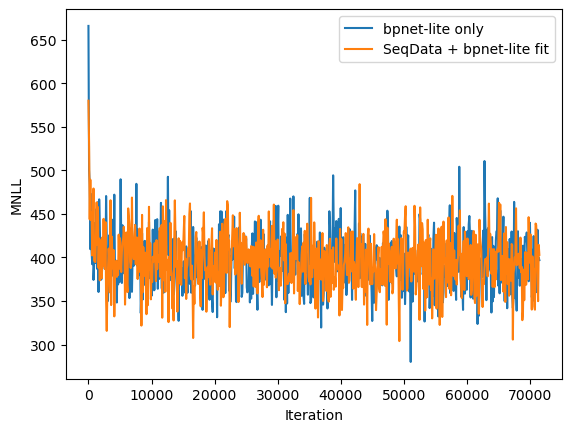

In [7]:
# Plot "Training MNLL" over "Iteration"
plt.plot(bpnetlite["Iteration"], bpnetlite["Training MNLL"], label="bpnet-lite only")
plt.plot(seqdata_bpnetlite["Iteration"], seqdata_bpnetlite["Training MNLL"], label="SeqData + bpnet-lite fit")
plt.xlabel("Iteration")
plt.ylabel("MNLL")
plt.legend()

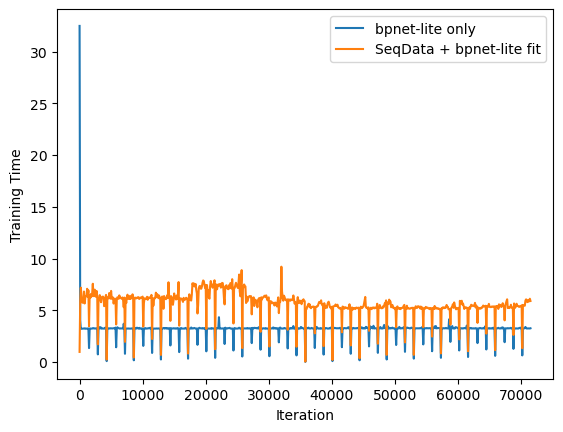

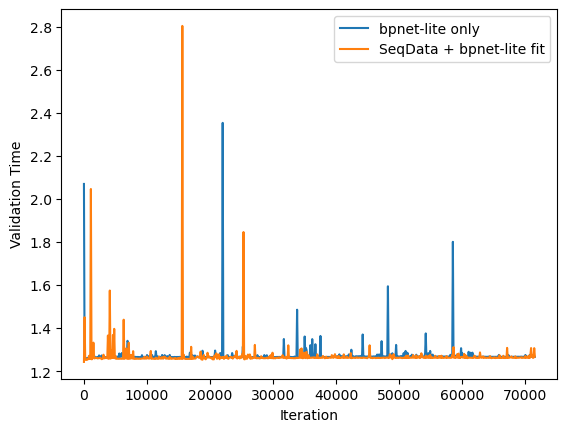

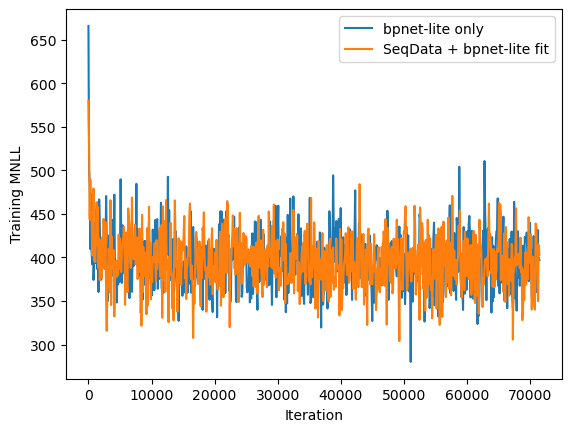

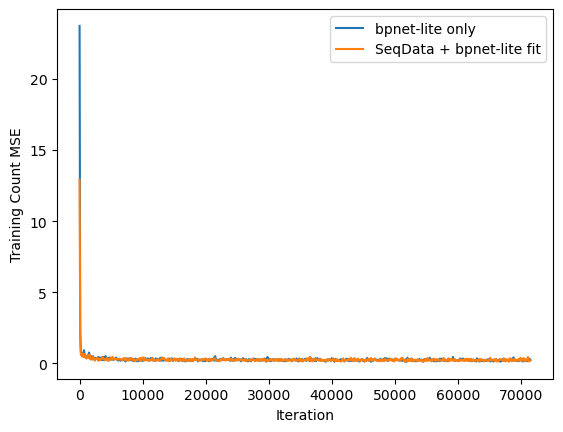

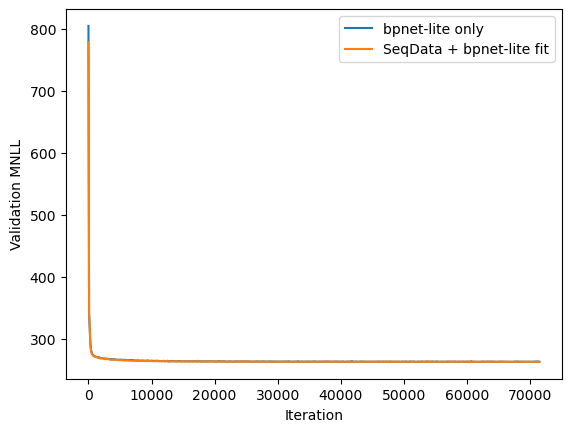

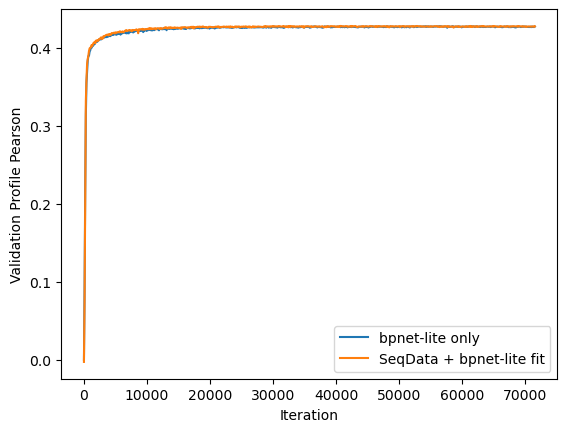

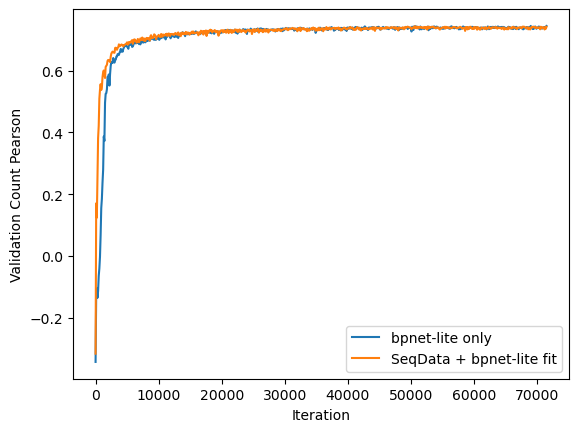

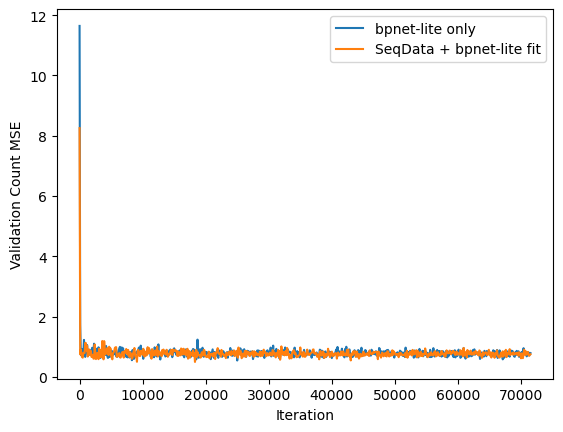

In [17]:
# Repeat the above cell for all columns in "cols_to_plot"
for col in cols_to_plot:
    plt.plot(bpnetlite["Iteration"], bpnetlite[col], label="bpnet-lite only")
    plt.plot(seqdata_bpnetlite["Iteration"], seqdata_bpnetlite[col], label="SeqData + bpnet-lite fit")
    plt.xlabel("Iteration")
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [10]:
# Collapse the dataframes on the "Epoch" column, keeping the last value for each epoch
bpnetlite_epoch = bpnetlite.groupby("Epoch").last()
seqdata_bpnetlite_epoch = seqdata_bpnetlite.groupby("Epoch").last()

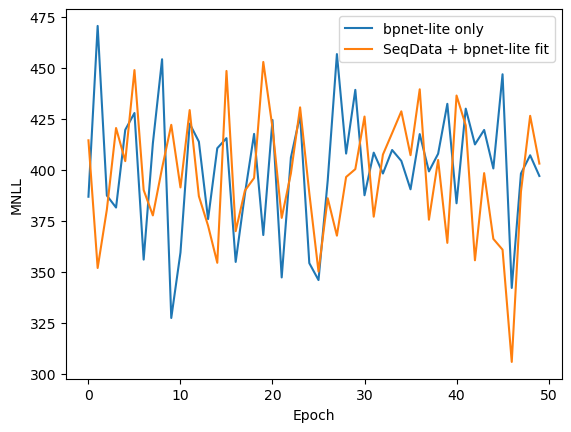

In [14]:
# Plot "Training MNLL" over "Epoch"
plt.plot(bpnetlite_epoch["Training MNLL"], label="bpnet-lite only")
plt.plot(seqdata_bpnetlite_epoch["Training MNLL"], label="SeqData + bpnet-lite fit")
plt.xlabel("Epoch")
plt.ylabel("MNLL")
plt.legend()